In [4]:
!pip install distancerasters
import requests
import json
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import fiona
import distancerasters as dr
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

  Using cached distancerasters-0.3.1-py3-none-any.whl (9.0 kB)
  Using cached rasterstats-0.16.0-py3-none-any.whl (16 kB)
  Using cached simplejson-3.17.6-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (136 kB)


In [5]:
# load AOI
with open(r'./Data/AmaBoundary.geojson') as inf:
    regions_dict = json.load(inf)

# Getting Market, Industry, Highway Geojson

In [7]:
# download market 

URL = 'https://api.ohsome.org/v1/elements/geometry'
data = {
    "bpolys": json.dumps(regions_dict),
    "time": "2022-01-01",
    "filter": "amenity=marketplace"
}
response = requests.post(URL, data=data)
display(response)

# download data
output = "./output/market.geojson"
with open(output, "w") as f:
    json.dump(response.json(), f)

<Response [200]>

In [8]:
df = gpd.read_file(output)
df.head(10)


,@osmId,@snapshotTimestamp,geometry
0,relation/10314706,2022-01-01T00:00:00+00:00,"POLYGON ((-0.23639 5.56673, -0.23563 5.56627, ..."
1,way/615474767,2022-01-01T00:00:00+00:00,"POLYGON ((-0.23079 5.62843, -0.23075 5.62842, ..."
2,way/615932400,2022-01-01T00:00:00+00:00,"POLYGON ((-0.22961 5.63093, -0.22957 5.63093, ..."
3,way/202488344,2022-01-01T00:00:00+00:00,"POLYGON ((-0.20999 5.54039, -0.20916 5.54050, ..."
4,way/666914878,2022-01-01T00:00:00+00:00,"POLYGON ((-0.21051 5.54840, -0.21053 5.54814, ..."
5,way/377954173,2022-01-01T00:00:00+00:00,"POLYGON ((-0.17778 5.62604, -0.17718 5.62586, ..."
6,way/414615655,2022-01-01T00:00:00+00:00,"POLYGON ((-0.20848 5.58119, -0.20689 5.58034, ..."
7,way/664056985,2022-01-01T00:00:00+00:00,"POLYGON ((-0.21699 5.56419, -0.21745 5.56419, ..."
8,way/261185626,2022-01-01T00:00:00+00:00,"POLYGON ((-0.23399 5.53047, -0.23383 5.53074, ..."
9,way/295106221,2022-01-01T00:00:00+00:00,"POLYGON ((-0.22729 5.55636, -0.22787 5.55561, ..."


<AxesSubplot:>

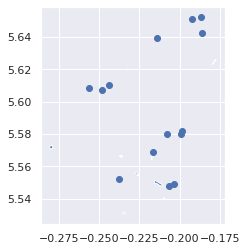

In [9]:
df.plot()

In [10]:
# download highway

URL = 'https://api.ohsome.org/v1/elements/geometry'
data = {
    "bpolys": json.dumps(regions_dict),
    "time": "2022-01-01",
    "filter": "highway=primary or highway=secondary"
}
response = requests.post(URL, data=data)
display(response)

# download data
output = "./output/highway.geojson"
with open(output, "w") as f:
    json.dump(response.json(), f)

<Response [200]>

In [11]:
df = gpd.read_file(output)
df.head()

,@osmId,@snapshotTimestamp,geometry
0,way/428712572,2022-01-01T00:00:00+00:00,"LINESTRING (-0.17563 5.55323, -0.17565 5.55322)"
1,way/11181574,2022-01-01T00:00:00+00:00,"LINESTRING (-0.22207 5.53127, -0.22216 5.53071..."
2,way/11524813,2022-01-01T00:00:00+00:00,"LINESTRING (-0.18124 5.56720, -0.18132 5.56724..."
3,way/11664722,2022-01-01T00:00:00+00:00,"LINESTRING (-0.21575 5.56968, -0.21578 5.56965..."
4,way/11665216,2022-01-01T00:00:00+00:00,"LINESTRING (-0.22918 5.54893, -0.22868 5.54782..."


<AxesSubplot:>

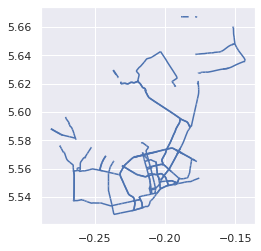

In [12]:
df.plot()

In [13]:
# download industry 

URL = 'https://api.ohsome.org/v1/elements/geometry'
data = {
    "bpolys": json.dumps(regions_dict),
    "time": "2022-01-01",
    "filter": "landuse = industrial"
}
response = requests.post(URL, data=data)
display(response)

# download data
output = "./output/industry.geojson"
with open(output, "w") as f:
    json.dump(response.json(), f)

<Response [200]>

In [14]:
df = gpd.read_file(output)
df.head()

,@osmId,@snapshotTimestamp,geometry
0,relation/3933987,2022-01-01T00:00:00+00:00,"POLYGON ((-0.22623 5.55427, -0.22613 5.55452, ..."
1,way/316141758,2022-01-01T00:00:00+00:00,"POLYGON ((-0.21804 5.53350, -0.21638 5.53352, ..."
2,way/222031755,2022-01-01T00:00:00+00:00,"POLYGON ((-0.20035 5.54731, -0.20033 5.54741, ..."
3,way/634431329,2022-01-01T00:00:00+00:00,"POLYGON ((-0.23360 5.63156, -0.23298 5.63194, ..."
4,way/634431330,2022-01-01T00:00:00+00:00,"POLYGON ((-0.23438 5.63109, -0.23397 5.63137, ..."


<AxesSubplot:>

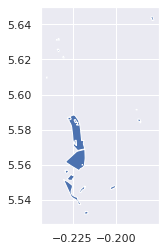

In [15]:
df.plot()

# Computing Euclidean Distance

In [19]:
!pip install fiona

In [17]:
import rasterio as rio 
import fiona
acc_image = rio.open('./Data/acc_img_bgrn.tif', mode="r") 
# does this tiff contains all the bans?
  
# load AOI
AOI = fiona.open(r'./Data/AmaBoundary.geojson', 'r') 

In [18]:
from glob import glob

filelist = glob("./output/*.geojson")
filelist

['./output/market.geojson',
 './output/ETH_ppt_20102.geojson',
 './output/highway.geojson',
 './output/train_set_points.geojson',
 './output/industry.geojson',
 './output/TRIAL_ETH_ppt_2010.geojson',
 './output/ETH_ppt_2010.geojson',
 './output/ET_webmerc.geojson']

In [19]:
filelist = ['./output/market.geojson',
 './output/highway.geojson',
 './output/industry.geojson']


In [20]:
filelist

['./output/market.geojson',
 './output/highway.geojson',
 './output/industry.geojson']

In [21]:
filename = ['market','highway','industry']

In [24]:
filename = []
    # generate distance array and output to geotifffilename = []
for file in filelist:
    head, tail = os.path.split(file)
    col_names=tail[:-8]
    filename.append(col_names)
    print('Filename: ',filename)
    print(30*'-')

Filename:  ['market']
------------------------------
Filename:  ['market', 'highway']
------------------------------
Filename:  ['market', 'highway', 'industry']
------------------------------


In [25]:
filename = ['market','highway','industry']

# Creating Market, Highway, Industry Bands

In [26]:
! mkdir out -p 

pixel_size =acc_image.res[0]
n = 0
for file in filelist:
    shp = fiona.open(file, "r")

    # create binary raster and affine
    rv_array, affine = dr.rasterize(shp, 
                                    pixel_size=pixel_size, 
                                    bounds=AOI.bounds)

    # generate distance array and output to geotiff
    my_dr = dr.DistanceRaster(rv_array, 
                              affine=affine,
                              output_path=f"out/{filename[n]}.tif")
    n += 1

Tree build time: 0.0229 seconds
Distance calc run time: 172.1299 seconds
Tree build time: 0.014 seconds
Distance calc run time: 173.115 seconds
Tree build time: 0.0157 seconds
Distance calc run time: 182.5785 seconds
